# Non-uniform sweeps
 - author: [Hamid Ali Syed](https://syedha.com)
 - date: May 25, 2023

## Description

**PyScanCf Example for non-uniform sweeps**

This example demonstrates the usage of PyScanCf with non-uniform radar sweeps. The radar data used in this example is from IMD Kolkata and consists of Type-C radar data, specifically Long Range PPI. The number of sweeps in each full volume scan can vary, with possibilities of 2, 3, 5, 6, etc. sweeps. Directly processing the data with PyScanCf may lead to errors due to this non-uniformity.

To overcome this, we first reorganize the data by moving the files to their respective directories based on the number of sweeps in each file. This step ensures that the data is properly organized and ready for further processing. Once the data is organized, we can then leverage PyScanCf's functionality to process the radar data.

By reorganizing the data and ensuring it is structured based on the number of sweeps, we can successfully utilize PyScanCf to generate desired outputs and perform operations on the data.

Please refer to the accompanying code for implementation details.


In [6]:
import xarray as xr
import pyscancf as pcf
import pyart
import glob
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
print(pcf.__version__)

1.0.24


In [21]:
import os
import shutil

def load_files_from_dir(raw_dir):
    file_list = os.listdir(raw_dir)
    return file_list

def process_file(file_path, organized_dir):
    ds = xr.open_dataset(file_path)
    sweep_number = ds.dims['sweep']
    
    # Create the directory
    directory_name = f"sweep_{sweep_number}"
    os.makedirs(os.path.join(organized_dir, directory_name), exist_ok=True)
    
    # Move the file to the directory
    destination_path = os.path.join(organized_dir, directory_name, os.path.basename(file_path))
    shutil.move(file_path, destination_path)
    
    print(f"File '{file_path}' moved to '{destination_path}'")


The two functions above are used to load the file names and to organize it which means it will first check for sweep numbers and then moves them to the directories based on sweep numbers.

In the next cell we are applying the the above written functions.

In [22]:

# Example usage
raw_dir = "./Kolkata/CAL220430IMD-C/"
organized_dir = "./Kolkata/organized/"
files = load_files_from_dir(raw_dir)

# Create 'organized' directory if it doesn't exist
os.makedirs(organized_dir, exist_ok=True)

for file in files:
    file_path = os.path.join(raw_dir, file)
    process_file(file_path, organized_dir)


File './Kolkata/CAL220430IMD-C/CAL220430170207-IMD-C.nc.4' moved to './Kolkata/organized/sweep_6/CAL220430170207-IMD-C.nc.4'
File './Kolkata/CAL220430IMD-C/CAL220430172209-IMD-C.nc' moved to './Kolkata/organized/sweep_6/CAL220430172209-IMD-C.nc'
File './Kolkata/CAL220430IMD-C/CAL220430170207-IMD-C.nc.3' moved to './Kolkata/organized/sweep_6/CAL220430170207-IMD-C.nc.3'
File './Kolkata/CAL220430IMD-C/CAL220430170207-IMD-C.nc' moved to './Kolkata/organized/sweep_6/CAL220430170207-IMD-C.nc'
File './Kolkata/CAL220430IMD-C/CAL220430174203-IMD-C.nc.1' moved to './Kolkata/organized/sweep_6/CAL220430174203-IMD-C.nc.1'
File './Kolkata/CAL220430IMD-C/CAL220430170000-IMD-C.nc.1' moved to './Kolkata/organized/sweep_2/CAL220430170000-IMD-C.nc.1'
File './Kolkata/CAL220430IMD-C/CAL220430180207-IMD-C.nc.2' moved to './Kolkata/organized/sweep_6/CAL220430180207-IMD-C.nc.2'
File './Kolkata/CAL220430IMD-C/CAL220430135206-IMD-C.nc.5' moved to './Kolkata/organized/sweep_6/CAL220430135206-IMD-C.nc.5'
File './

This cell is to check how many folders were created, and also save those folder names in order to load the data to make it cfradial, as you can see we have only two types of volume scans available i.e., some volumes contain 2 sweeps, and some 6.

In [23]:
def load_folder_names(organized_dir):
    folder_names = next(os.walk(organized_dir))[1]
    return folder_names

# Example usage
organized_dir = "./Kolkata/organized/"
folders = load_folder_names(organized_dir)
print(folders)

['sweep_2', 'sweep_6']


Now we can make the raw imd data as cfradial using PyScanCf's cfrad function

In [25]:
input_dir = "./Kolkata/organized/"
output_dir = "./Kolkata/output_directory/"

folders = load_folder_names(input_dir)

for folder_name in folders:
    folder_path = os.path.join(input_dir, folder_name)
    sweep_number = int(folder_name.split("_")[1])
    pcf.cfrad(input_dir=folder_path, output_dir=output_dir, scan_type="C", nf=sweep_number)


Number of files:  52
Total number of files will be created:  26
Merging all scans in one file
Data merging done 
Total Time Elapsed:  0:38:47.131566
Number of files:  162
Total number of files will be created:  27
Merging all scans in one file
Data merging done 
Total Time Elapsed:  0:38:54.350641


The below code is to transform the data to gridded format. Its resolution will be 81, 601, 601 for z,y,x, respectively. Here I have done it for only one file, so if you want to do it for all the data, you can remove `[0:1]` and it should look like as given below
```{python}
for cfile in cfiles:
    radar = pyart.io.read(cfile)
```
Also, `height=10` and `length=250` are in `km`.

In [104]:
# Define the output directory for grids
gridded_dir = "./Kolkata/gridded/"
os.makedirs(gridded_dir, exist_ok=True)

# Converting to grids
cfiles = sorted(glob.glob(output_dir + "*.nc"))
for cfile in cfiles[0:1]: # remove the [0:1], and keep it like cfiles: only to transform all the files
    radar = pyart.io.read(cfile)
    grid = pcf.get_grid(radar=radar, grid_shape=(81, 601, 601), height=10, length=250)
    filename = os.path.basename(cfile)
    output_path = os.path.join(gridded_dir, f"grid_{filename}")
    print(f"File saved in {gridded_dir} as grid_{filename}")
    pyart.io.write_grid(filename=output_path, grid=grid, write_proj_coord_sys=True, write_point_lon_lat_alt=True)


In [111]:
# verify gridded file
grid_radar = xr.open_dataset("./Kolkata/gridded/grid_cfrad_CAL220430112010-IMD-C.nc")
grid_radar = grid_radar.set_coords({'point_longitude','point_latitude'})

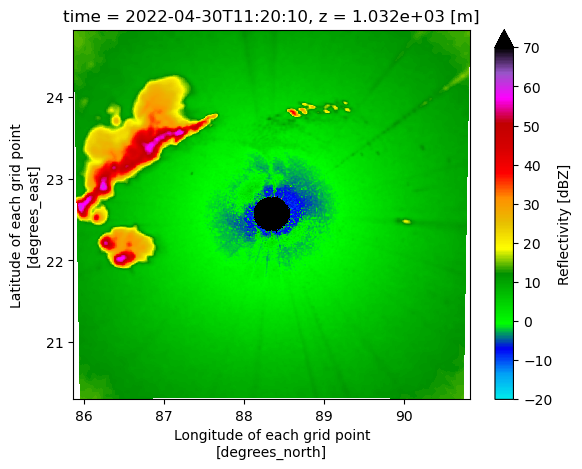

In [113]:
grid_radar['REF'].isel(time=0).sel(z=1000, method='nearest').plot.pcolormesh(x='point_longitude', y='point_latitude',
                                                                             vmin = -20, vmax = 70, cmap='pyart_NWSRef')